# User Classification using In-Context Learning

**Date:** 10th December 2024

**Dataset:** German Web Tracking

This notebook evaluates user identification using `gpt-4o-mini` through in-context learning. We analyze how well the model can identify users based on their web browsing patterns by:
- Training on a set of user sequences
- Testing on held-out sequences mixed with other users' sequences
- Computing precision, recall, F1 and accuracy metrics

**Summary:**
- The model demonstrates ability to identify users from web browsing patterns using in-context learning
- Performance exceeds random baseline but shows significant variation across users
- Further analysis needed to understand confidence-accuracy relationship

In [1]:
import sys
import os

sys.path.append(os.path.abspath("../../"))

In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML

from cybergpt.prompting.classification import (
    compute_metrics,
    plot_metrics,
    create_html_table,
)

## Data

In order to generate the required processed data, please run the following:

**Contrastive Dataset**

```shell
python -m cybergpt.eval.contrastive
```

This command will create a dataset consisting, for each user, of a set of training sequences, a set of test sequences and a set of sequences from other users of the same size as the set of test sequences. The test sequences together with the set of sequences from other users form a contrastive set for classification tasks.

**Classification Results**

```shell
python -m cybergpt.prompting.classification \
        --dataset_path data/contrastive/classification_dataset.pkl \
        --system-prompt cybergpt/prompting/class_system_prompt.txt \
        --output-path data/contrastive/classification_results.pkl \
        --sample-size 200 \
        --max-system-tokens 90000
```

This command will choose a subset of 200 users and ask `gpt-4o-mini`, for each user, to determine which of the sequences in the contrastive set actually correspond to the user.

In [3]:
results = pickle.load(open("../../data/contrastive/classification_results.pkl", "rb"))

## Results

Evaluation metrics:
- Overall metrics (precision, recall, F1, accuracy)
- Confidence-level metrics (low, medium, high)
- Per-user metrics to analyze individual performance

In [4]:
metrics = compute_metrics(results)

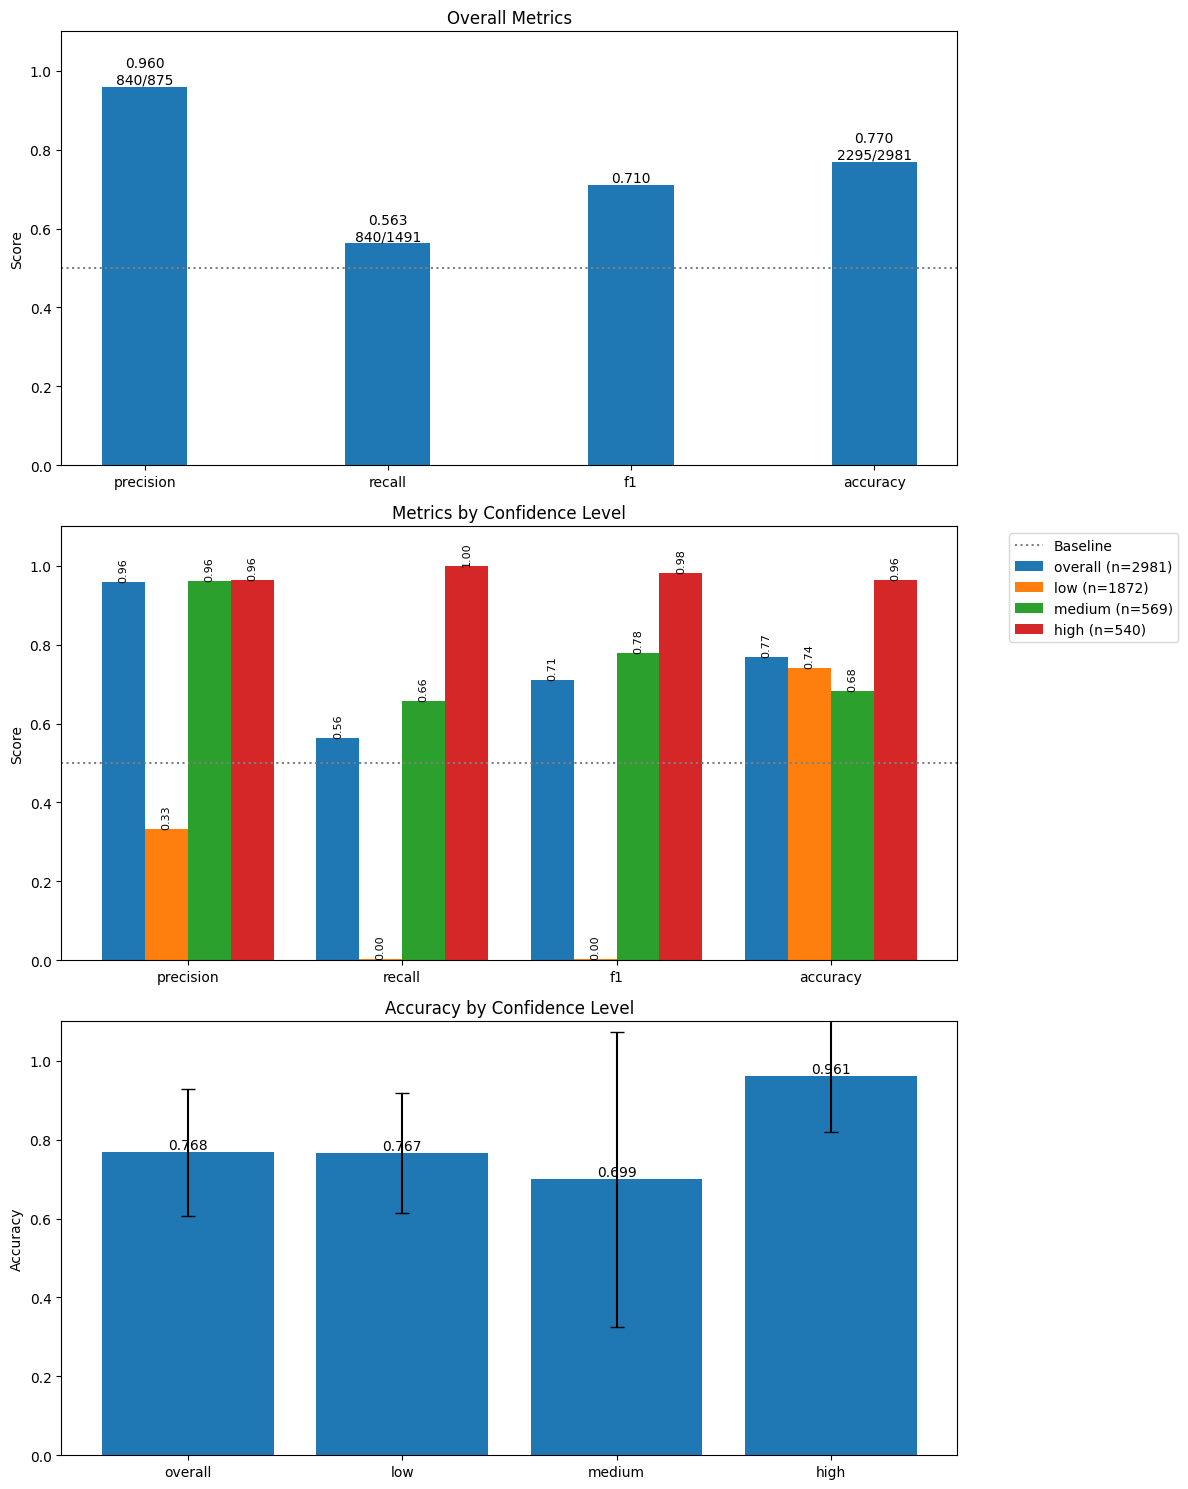

In [5]:
plot_metrics(metrics)
plt.show()

Each contrastive sets consists of exactly 50% positives, so the mean accuracy should be compared to 0.5.

The plots show:
1. Overall metrics compared to 0.5 baseline
2. Performance breakdown by (model's self-reported) confidence level
3. Accuracy distribution with error bars

Key findings:
- Model performs above random baseline (0.5)
- Higher confidence correlates with better accuracy
- Significant variance in per-user performance

## Low Recall Example

Overall recall is low; in fact, it's 0 for a few of the users indicating that the model always predicts `False` in these cases. Below we look at an example of the reasoning that `gpt-4o-mini` gives for a situation where the model has least medium confidence that sequences do not belong to the same user, even though they do.

In [6]:
low_recall_example = [
    r for r in results if not any([m["match"] for m in r["response_json"]])
][5]

In [7]:
html_str = create_html_table(
    [
        (t, r["confidence"], r["reasoning"])
        for b, r, t in zip(
            low_recall_example["belongs_to_class"],
            low_recall_example["response_json"],
            low_recall_example["test_values"],
        )
        if b
    ]
)

In [8]:
display(HTML(html_str))

The example above shows a case where the model only reports False, failing to identify any of the user's sequences. The confidence levels and reasoning suggest the model may be:
- Quite conservative in making positive matches
- Overly focused on specific patterns rather than general browsing behavior
- Struggling with temporal variations in browsing patterns